In [ ]:
import mxnet as mx
from mxnet import init, gluon, nd, autograd, image
from mxnet.gluon import nn
import numpy as np
import pickle as p
import matplotlib.pyplot as plt
from time import time
ctx = mx.gpu()

In [1]:
def load_cifar(route = '/home/sinyer/python/data/cifar-10-batches-py', train_num = 50000, test_num = 10000):
    def load_batch(filename):
        with open(filename, 'rb')as f:
            data_dict = p.load(f, encoding='latin1')
            X = data_dict['data']
            Y = data_dict['labels']
            X = X.reshape(10000, 3, 32,32).astype("float")
            Y = np.array(Y)
            return X, Y
    def load_labels(filename):
        with open(filename, 'rb') as f:
            label_names = p.load(f, encoding='latin1')
            names = label_names['label_names']
            return names
    label_names = load_labels(route + "/batches.meta")
    x1, y1 = load_batch(route + "/data_batch_1")
    x2, y2 = load_batch(route + "/data_batch_2")
    x3, y3 = load_batch(route + "/data_batch_3")
    x4, y4 = load_batch(route + "/data_batch_4")
    x5, y5 = load_batch(route + "/data_batch_5")
    test_pic, test_label = load_batch(route + "/test_batch")
    train_pic = np.concatenate((x1, x2, x3, x4, x5))
    train_label = np.concatenate((y1, y2, y3, y4, y5))
    train_pic = train_pic[:train_num].astype('float32')/255
    train_label = train_label[:train_num].astype('float32')
    test_pic = test_pic[:test_num].astype('float32')/255
    test_label = test_label[:test_num].astype('float32')
    return train_pic, train_label, test_pic, test_label

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

def apply(img):
    aug_train = image.CreateAugmenter(data_shape=(3, 32, 32), rand_crop=True, rand_mirror=True)
    for aug in aug_train:
        img = aug(img)
    return img

def transform(data): 
    data = nd.pad(data, pad_width=(0,0,0,0,2,2,2,2),mode='constant',constant_value=0)
    data = nd.transpose(data, (0,2,3,1))
    data = nd.stack(*[apply(d) for d in data])
    data = nd.transpose(data, (0,3,1,2))
    return data

In [2]:
class Residual(nn.Block):
    def __init__(self, channels, same_shape=True, equal=True, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.same_shape = same_shape
        self.equal = equal
        with self.name_scope():
            strides = 1 if same_shape else 2
            self.bn1 = nn.BatchNorm()
            self.conv1 = nn.Conv2D(channels, kernel_size=3, padding=1, strides=strides)
            self.bn2 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels, kernel_size=3, padding=1)
            if (not same_shape) or (not equal):
                self.conv3 = nn.Conv2D(channels, kernel_size=1, strides=strides)
    def forward(self, x):
        out = self.conv1(nd.relu(self.bn1(x)))
        out = self.conv2(nd.relu(self.bn2(out)))
        if (not self.same_shape) or (not self.equal):
            x = self.conv3(x)
        return out + x

class ResNet(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        with self.name_scope(): 
            net = self.net = nn.Sequential()
            net.add(nn.Conv2D(channels=16, kernel_size=3, strides=1, padding=1))
            net.add(Residual(channels=16*8, equal=False))
            net.add(Residual(channels=16*8), Residual(channels=16*8))            
            net.add(Residual(channels=32*8, same_shape=False))
            net.add(Residual(channels=32*8), Residual(channels=32*8))
            net.add(Residual(channels=64*8, same_shape=False))
            net.add(Residual(channels=64*8), Residual(channels=64*8))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.AvgPool2D(pool_size=8))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
    def forward(self, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
        return out

In [ ]:
train_pic, train_label, test_pic, test_label = load_cifar()

batch_size = 128
train_pic = np.transpose(train_pic, (0,2,3,1))
test_pic = np.transpose(test_pic, (0,2,3,1))
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
for i in range(3):
    train_pic[:,:,:,i] = (train_pic[:,:,:,i] - mean[i])/std[i]
    test_pic[:,:,:,i] = (test_pic[:,:,:,i] - mean[i])/std[i]
train_pic = np.transpose(train_pic, (0,3,1,2))
test_pic = np.transpose(test_pic, (0,3,1,2))
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_pic, train_label), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_pic, test_label), batch_size, shuffle=False)

In [3]:
net = ResNet(10)
net.initialize(ctx=ctx, init=init.Xavier())
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 5e-4})

E 0; L 1.551213; Tr_acc 0.434215; Te_acc 0.506626; T 127.811663
E 10; L 0.401198; Tr_acc 0.862080; Te_acc 0.849881; T 124.254874
E 20; L 0.332388; Tr_acc 0.885810; Te_acc 0.812104; T 124.134300
E 30; L 0.300521; Tr_acc 0.896871; Te_acc 0.842959; T 124.128216
E 40; L 0.283903; Tr_acc 0.902873; Te_acc 0.837520; T 233.438447
E 50; L 0.273838; Tr_acc 0.904959; Te_acc 0.809237; T 123.536731
E 60; L 0.135791; Tr_acc 0.956278; Te_acc 0.940862; T 169.767161
E 70; L 0.038289; Tr_acc 0.988527; Te_acc 0.928402; T 123.652133
E 80; L 0.062437; Tr_acc 0.979596; Te_acc 0.914953; T 124.019291
E 90; L 0.057762; Tr_acc 0.980974; Te_acc 0.928797; T 123.741798
E 100; L 0.056715; Tr_acc 0.981434; Te_acc 0.922567; T 124.098962
E 110; L 0.055687; Tr_acc 0.982405; Te_acc 0.919600; T 169.695700
E 120; L 0.018291; Tr_acc 0.995165; Te_acc 0.950158; T 123.580315
E 130; L 0.002160; Tr_acc 0.999980; Te_acc 0.957971; T 123.524619
E 140; L 0.001833; Tr_acc 1.000000; Te_acc 0.958762; T 123.440911
E 150; L 0.001799; Tr

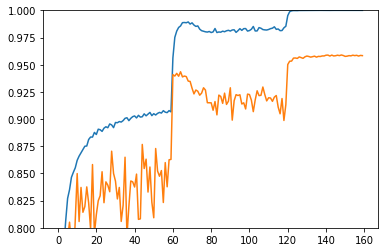

In [4]:
epochs = 160

a = []
b = []
for epoch in range(epochs):
    if epoch == 60:
        trainer.set_learning_rate(0.02)
    if epoch == 120:
        trainer.set_learning_rate(0.004)
    if epoch == 140:
        trainer.set_learning_rate(0.0008)
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = transform(data).as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        trainer.step(data.shape[0])
        train_loss += nd.mean(l).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%10 == 0:
        print("E %d; L %f; Tr_acc %f; Te_acc %f; T %f" % (epoch, train_loss / batch, train_acc / batch, test_acc, time() - start))
print("Tr_acc %f; Te_acc %f" % (train_acc / batch, test_acc))
plt.plot(np.arange(epochs), a, np.arange(epochs), b)
plt.ylim(0.6,1)
plt.show()